# Introduction
Colorectal cancer is among highly mortal cancers in several countries, assumingly because of the diet that is brought about the modern life style. This notebook is going to fit a model on "NCT-CRC-HE-100k" dataset which is published by "National Center for Tumor Diseases", headquarted in Heidelburg, Germany. The slides in this dataset are hand-delineated by Kather et al., to create non-overlapping image patches which belong to nine classes: adipose, background, debris, lymphocytes, mucus, smooth muscle, normal colon mucosa, cancer-associated stroma, and CRC epithelium. These classes are all possible elements of every histopathologic colorectal cancer image, including normal and tumor tissues.
. Data is categorized as follows:
1.	ADI: adipose tissue, consists of adipocytes
2.	BACK: background of histopathological images
3.	DEB: debris, usefull for diagnosis of cancer
4.	LYM: lymphocytes, cells of lymphatic system
5.	MUC: mucus, protective layer on tissue
6.	MUS: smooth muscle
7.	NORM: normal tissue of colon
8.	STR: stroma tissue associated with cancer
9.	TUM: epithelium tissues of adenocarcinoma

We are aspired to apply transfer learning technique in our work by training the wheights of VGG19 model on afforementioned dataset.

# 1. Commencing by Groundworks

In [12]:
# Imports
import os, warnings, cv2
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import pandas as pd

from os import listdir
from os.path import isfile, join
from shutil import rmtree

from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification

In [13]:

#Load the directory
main_path = '../input/nct-crc-he-100k/NCT-CRC-HE-100K'
sub_dir =os.listdir(main_path)

Creating a dataframe containing our data could enable us shuffle, partly remove or simply work with it with the use of Pands library, without concering of heavy image data.

In [14]:
#Creat The DataFrame
Data_df=pd.DataFrame({'ID': [], 'Class':[]})

for subdir in sub_dir:
    mypath = join(main_path,subdir)
    files=[f for f in listdir(mypath)]
    classes=[subdir for c in files]
    files_df = pd.DataFrame({'ID':files, 'Class':classes})
    Data_df = Data_df.append(files_df)

Data_df

,ID,Class
0,MUC-GQLYEALK.tif,MUC
1,MUC-FYTGWFGD.tif,MUC
2,MUC-AVNDTFWS.tif,MUC
3,MUC-DQPFGFLS.tif,MUC
4,MUC-FNEDYLHG.tif,MUC
...,...,...
10441,STR-NQFCFNPH.tif,STR
10442,STR-KPWLGGCI.tif,STR
10443,STR-FFCLCFPE.tif,STR
10444,STR-HGPELQKY.tif,STR


# 2.Visualizing the Data
A sense of the problem might be caught, when we visulizing the distribution of the data. Most of the time, imblanced dataset cannot yield a quality model, but as it is displayed below it should not be a source of concern here. 
Also, a presentation of the patches whitin our data, suggests that the patches from different classes are quite distinguishable, therefore, any problem is not imaginable in this place.

Distribution of classes is as followed:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: Class, dtype: int64 
 


 
 
 



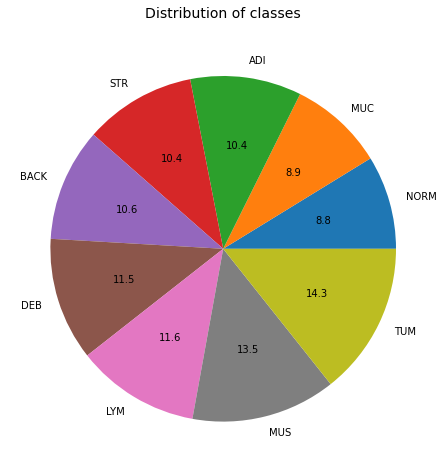

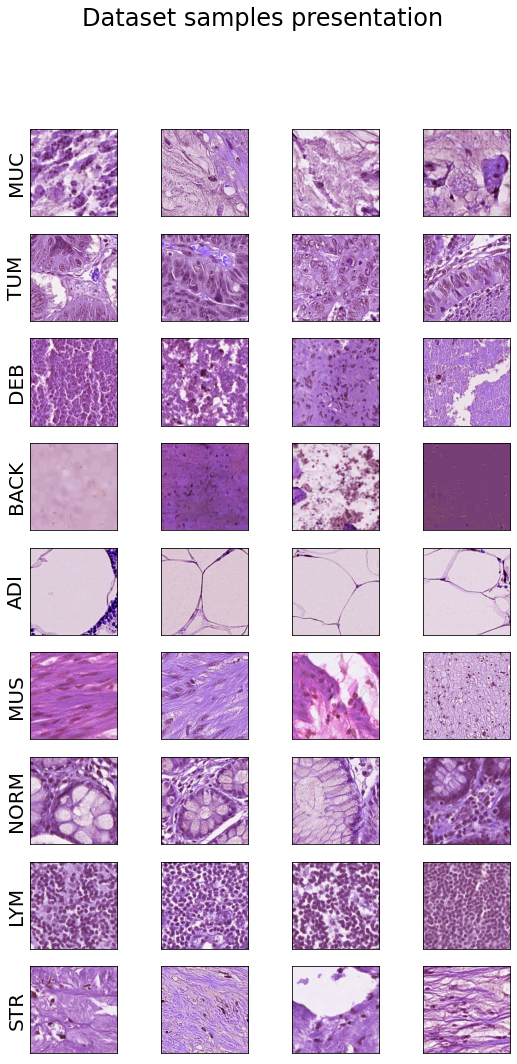

In [15]:
# Distribution of the Classes
class_of_patch = Data_df.Class.value_counts()
print('Distribution of classes is as followed:\n{}'.format(class_of_patch[::-1]),'\n','\n')

pie_fig = plt.figure(figsize=(6,7))
pie_axis = pie_fig.add_axes([0,0,1,1])
pie_axis.pie(class_of_patch[::-1],labels=['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM'],startangle=0,autopct='%1.1f')
pie_fig.suptitle('Distribution of classes',size=14)



# Display some random samples from dataset
samp_fig, axis = plt.subplots(9,4,figsize=(9,17))
samp_fig.suptitle('Dataset samples presentation',size=24)

print('\n','\n','\n','\n')
for subdir in sub_dir:
    samples = Data_df.loc[Data_df['Class']==subdir].sample(4)
    imgs = []
    for sample in samples['ID']:
        path = join(main_path,subdir,sample)
        img = cv2.imread(path)
        imgs.append(img)
    
    
    for i , img in enumerate(imgs):
        axis[sub_dir.index(subdir),i].set_xticks([])
        axis[sub_dir.index(subdir),i].set_yticks([])
        axis[sub_dir.index(subdir),i].imshow(img)
        axis[sub_dir.index(subdir),0].set_ylabel('{}'.format(subdir),size=20)

# 3. Spliting The Data to Training and Validation Sets
On the basis of our dataframe, now we can split our dataset for the use of training, validation and testing. Further, we can plot quantities of each set to check for any imbalance between same classes of each set. Altough it is not necessary, because this issue is considered in the used module from sklearn library.

In [17]:
# split validation and training data
y_1 = Data_df['Class']

train_test_df, val_df = train_test_split(Data_df,train_size = 0.85,random_state=101,shuffle=True,stratify=y_1 ) 

y_2 = train_test_df['Class']

train_df, test_df = train_test_split(train_test_df,train_size=0.823529,random_state=101,shuffle=True,stratify=y_2)

Class Distribution of Training Examples:
TUM     10021
MUS      9475
LYM      8090
DEB      8058
BACK     7396
STR      7312
ADI      7285
MUC      6228
NORM     6134
Name: Class, dtype: int64 
 
 
 

Class Distribution of Validation Examples:
TUM     2148
MUS     2030
LYM     1734
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1314
Name: Class, dtype: int64 
 
 
 

Class Distribution of Test Examples:
TUM     2148
MUS     2031
LYM     1733
DEB     1727
BACK    1585
STR     1567
ADI     1561
MUC     1334
NORM    1315
Name: Class, dtype: int64 
 
 
 



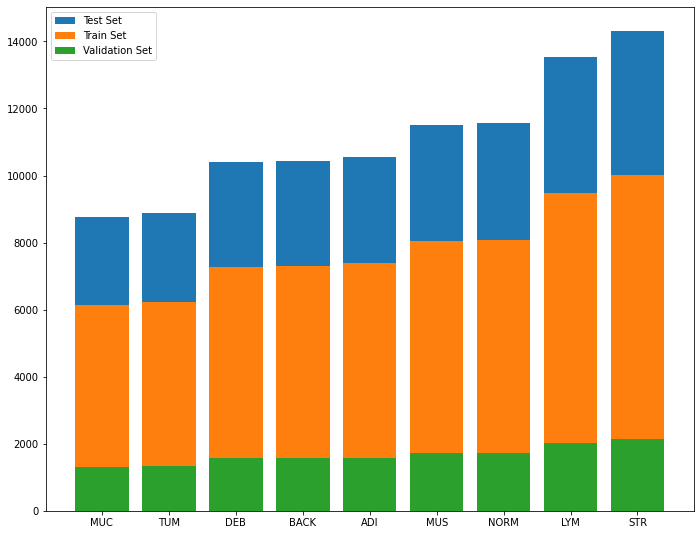

In [18]:
#check the distribution of data in training and validation sets
class_of_train_patch = train_df.Class.value_counts()
class_of_val_patch = val_df.Class.value_counts()
class_of_test_patch = test_df.Class.value_counts()

print('Class Distribution of Training Examples:\n{}'.format(class_of_train_patch),'\n','\n','\n','\n')
print('Class Distribution of Validation Examples:\n{}'.format(class_of_val_patch),'\n','\n','\n','\n')
print('Class Distribution of Test Examples:\n{}'.format(class_of_test_patch),'\n','\n','\n','\n')

#Bar plot for checking the distribution

bar_fig = plt.figure(figsize=(9,7))
bar_axis = bar_fig.add_axes([0,0,1,1])

bar_axis.bar(sub_dir,class_of_patch[::-1],label= 'Test Set')
bar_axis.bar(sub_dir,class_of_train_patch[::-1], label = 'Train Set')
bar_axis.bar(sub_dir,class_of_val_patch[::-1], label = 'Validation Set')


bar_axis.legend()

## Creating Folders for Writing Split Data in
For Convinience. it is better to write the splitted sets of data to seperated directories. In that way,we could simply call them from the directory into our generator.

In [19]:
main_dir = 'SplittedData'
os.mkdir(main_dir)

train_dir = join(main_dir,'Training')
os.mkdir(train_dir)

val_dir = join(main_dir,'Validation')
os.mkdir(val_dir)

test_dir = join(main_dir,'Test')
os.mkdir(test_dir)


for subdir in range(len(sub_dir)):
    train_sub_dir = join(train_dir,sub_dir[subdir])
    os.mkdir(train_sub_dir)
    
    val_sub_dir = join(val_dir,sub_dir[subdir])
    os.mkdir(val_sub_dir)
    
    test_sub_dir = join(test_dir,sub_dir[subdir])
    os.mkdir(test_sub_dir)

FileExistsError: [Errno 17] File exists: 'SplittedData'

## Writing the splitted data in folders

In [20]:
Data_df.set_index('ID', inplace=True)

for img in train_df['ID']:
    label = Data_df.loc[img,'Class']
    source = join(main_path,label,img)
    dest = join(train_dir,label,img)
    
    cv2_img = cv2.imread(source)
    cv2.imwrite(dest,cv2_img)

    
for img in val_df['ID']:
    label = Data_df.loc[img,'Class']
    source = join(main_path,label,img)
    dest = join(val_dir,label,img)
    
    cv2_img = cv2.imread(source)
    cv2.imwrite(dest,cv2_img)

    
for img in test_df['ID']:
    label = Data_df.loc[img,'Class']
    source = join(main_path,label,img)
    dest = join(test_dir,label,img)
    
    cv2_img = cv2.imread(source)
    cv2.imwrite(dest,cv2_img)

# 4. Data Augmentation
Data augmention recognised as a reliable technic to overcome flaws like overfitting and imblance. alongside, the "ImageDataGenerator" module, provides some tools that are helpful for feeding data to our model. Here, we only used horizontal and vertical flips generators on our data.

In [21]:
img_size = 224
img_channel=3
input_shape=(img_size,img_size,img_channel)
BATCH_size =120
learning_rate = 3E-4
train_step = (len(train_df)/BATCH_size)
val_step = (len(val_df)/BATCH_size)

datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, vertical_flip = True)

train_ds= datagen.flow_from_directory(train_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = True,
                                     seed = 101,
                                     interpolation = 'nearest',
                                     class_mode='categorical')
val_ds = datagen.flow_from_directory(val_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

test_ds = datagen.flow_from_directory(test_dir,
                                     target_size=(img_size,img_size),
                                     batch_size=BATCH_size,
                                     shuffle = False,
                                     interpolation = 'nearest',
                                     class_mode='categorical')

print(train_ds.class_indices)

Found 69999 images belonging to 9 classes.
Found 15000 images belonging to 9 classes.
Found 15001 images belonging to 9 classes.
{'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}


# 5. Transfer learning 
VGG19 architecture is already deployed in application module of keras API, so there is no need to build the model from scratch. We are using standard workflow recommended by [Keras](http://keras.io/guides/transfer_learning/), which is consists of two main steps__ weight-fetching and fine-tuning.

## Callbacks

In [22]:
saved_model_path = 'modelinception.h5'
checkpoint = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, 
                                   verbose=1, mode='max',min_delta=0.001, min_lr=0.0000001)

## Weight-Fetching
The attempt in this part is to utilize a pre-trained model on a different dataset, whitout any change in the weights trained on the first data. Of course for this purpose, only two last added layers remained trainable in following training session. 

2022-11-15 05:52:17.473524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 05:52:17.586020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 05:52:17.586818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 05:52:17.595932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1161      
Total params: 23,236,937
Trainable params: 3,212,553
Non-trainable params: 20,024,384
_________________________________________________________________
None


2022-11-15 05:52:23.071884: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 72253440 exceeds 10% of free system memory.
2022-11-15 05:52:23.467797: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-11-15 05:52:25.235352: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 72253440 exceeds 10% of free system memory.
2022-11-15 05:52:26.339398: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  2/583 [..............................] - ETA: 2:33 - loss: 3.5259 - accuracy: 0.1542   

2022-11-15 05:52:26.547525: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 72253440 exceeds 10% of free system memory.
2022-11-15 05:52:42.390333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 72253440 exceeds 10% of free system memory.


  3/583 [..............................] - ETA: 6:57 - loss: 4.1450 - accuracy: 0.1667

2022-11-15 05:52:43.560717: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 72253440 exceeds 10% of free system memory.


583/583 [==============================] - 728s 1s/step - loss: 0.4441 - accuracy: 0.8546 - val_loss: 0.3031 - val_accuracy: 0.8996

Epoch 00001: val_loss improved from inf to 0.30312, saving model to modelinception.h5
Epoch 2/5
583/583 [==============================] - 626s 1s/step - loss: 0.2650 - accuracy: 0.9097 - val_loss: 0.2592 - val_accuracy: 0.9097

Epoch 00002: val_loss improved from 0.30312 to 0.25917, saving model to modelinception.h5
Epoch 3/5
583/583 [==============================] - 572s 981ms/step - loss: 0.2297 - accuracy: 0.9220 - val_loss: 0.2385 - val_accuracy: 0.9171

Epoch 00003: val_loss improved from 0.25917 to 0.23846, saving model to modelinception.h5
Epoch 4/5
583/583 [==============================] - 599s 1s/step - loss: 0.2088 - accuracy: 0.9284 - val_loss: 0.2321 - val_accuracy: 0.9202

Epoch 00004: val_loss improved from 0.23846 to 0.23211, saving model to modelinception.h5
Epoch 5/5
583/583 [==============================] - 595s 1s/step - loss: 0.194

<AxesSubplot:>

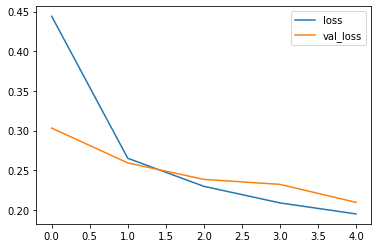

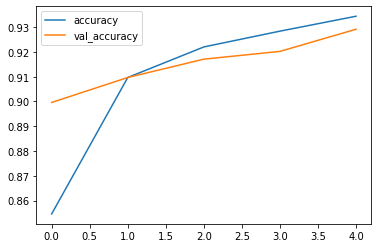

In [23]:

Base_model = VGG19(include_top=False , input_shape=(224,224,3), classifier_activation = 'softmax', weights = 'imagenet')
Base_model.trainable = False

model = keras.Sequential([
        Base_model,
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(9, activation='softmax')
    ])
    
model.compile(
    optimizer=keras.optimizers.Adam(epsilon = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])
print(model.summary())


history = model.fit(
    train_ds,
    steps_per_epoch= train_step,
    shuffle = True,
    validation_data = val_ds,
    validation_steps = val_step,
    verbose = 1,
    epochs = 5,
    callbacks = [checkpoint])


hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()

## Fine-Tuning
This part is going to make our model to adapt to our data as well as possible. As we set before, mini batch of size 50 could be promissing for both not running the out of memory and also getting a quality model. During the training session learning rate is monitored and decrease from the initialed amount, if accuracy of model on validation set not improves for 2 epochs.

In [24]:
model.load_weights('modelinception.h5')

Base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, epsilon = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

history = model.fit(
    train_ds,
    steps_per_epoch= train_step,
    shuffle = True,
    validation_data = val_ds,
    validation_steps = val_step,
    verbose = 1,
    epochs = 8,
    callbacks=[checkpoint,reduce_lr])

# serialize model to JSON
model_json = model.to_json()
with open("CRC_modelinception.json", "w") as json_file:             
     json_file.write(model_json) 

# serialize weights to HDF5
model.save_weights("CRC_modelinception.h5")
print("Saved model to disk")

Epoch 1/8
583/583 [==============================] - 701s 1s/step - loss: 0.1287 - accuracy: 0.9580 - val_loss: 0.0985 - val_accuracy: 0.9669

Epoch 00001: val_loss improved from 0.20945 to 0.09853, saving model to modelinception.h5
Epoch 2/8
583/583 [==============================] - 691s 1s/step - loss: 0.0776 - accuracy: 0.9754 - val_loss: 0.0685 - val_accuracy: 0.9772

Epoch 00002: val_loss improved from 0.09853 to 0.06851, saving model to modelinception.h5
Epoch 3/8
583/583 [==============================] - 693s 1s/step - loss: 0.0584 - accuracy: 0.9810 - val_loss: 0.0570 - val_accuracy: 0.9805

Epoch 00003: val_loss improved from 0.06851 to 0.05698, saving model to modelinception.h5
Epoch 4/8
583/583 [==============================] - 693s 1s/step - loss: 0.0463 - accuracy: 0.9847 - val_loss: 0.0546 - val_accuracy: 0.9826

Epoch 00004: val_loss improved from 0.05698 to 0.05459, saving model to modelinception.h5
Epoch 5/8
583/583 [==============================] - 689s 1s/step - 

# 6. Model Evaluation
learning curves does not show any sign of underfitting, nor overfitting. The trend is relatively flat and without any osciallation which display proper choice of batch size and learning rate.

15000/15000 [==============================] - 101s 7ms/step - loss: 0.0359 - accuracy: 0.9881
val_loss: 0.03592778742313385
val_acc: 0.9880666732788086


<AxesSubplot:>

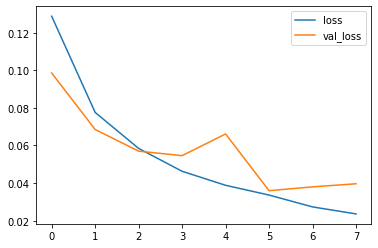

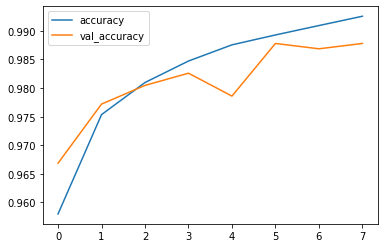

In [25]:
#Learning Curves

model.load_weights('modelinception.h5')

val_loss, val_acc = model.evaluate(val_ds, 
                        steps=len(val_df))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

hist_df = pd.DataFrame(history.history)
hist_df.loc[:,['loss','val_loss']].plot()
hist_df.loc[:,['accuracy','val_accuracy']].plot()

# 7. Prediction on Test set 
Since we have not a single set of metrics, because the validation metrics were for different epochs, we use our test set to acquire metrics based on which our model can be described. It can be interpreted from the report that model is enabled to distinguish between different classes, due to high precission, recall and f1 score. Also as a general metric, our accuracy is highly acceptable.

126/126 [==============================] - 123s 978ms/step
[0 0 0 ... 8 8 8]
[0 0 0 ... 8 8 8]
[[1554    1    0    0    3    3    0    0    0]
 [   0 1584    1    0    0    0    0    0    0]
 [   0    0 1704    5    0    1    1   13    3]
 [   0    0    0 1730    0    0    1    1    1]
 [   1    0    1    0 1313    3    1   12    3]
 [   0    0    0    0    1 2014    0   16    0]
 [   0    0    0    4   10    1 1283    1   16]
 [   0    0    5    0    3   24    0 1534    1]
 [   0    0    6    2    7    3   11    9 2110]]
              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00      1561
        BACK       1.00      1.00      1.00      1585
         DEB       0.99      0.99      0.99      1727
         LYM       0.99      1.00      1.00      1733
         MUC       0.98      0.98      0.98      1334
         MUS       0.98      0.99      0.99      2031
        NORM       0.99      0.98      0.98      1315
         STR       0.97      0.98      

<AxesSubplot:>

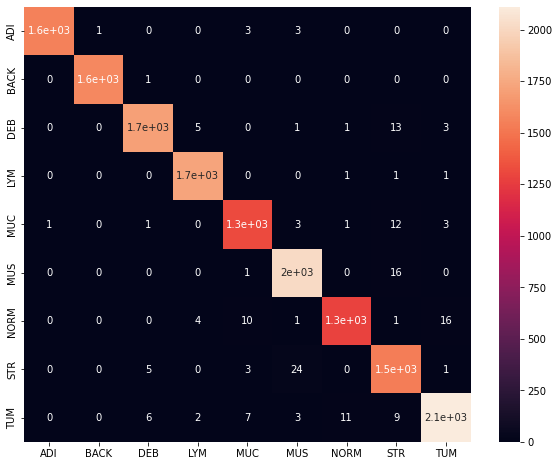

In [26]:
predictions = model.predict(test_ds, verbose=1)

y_true = test_ds.classes
print(y_true)

y_pred=np.argmax(predictions,axis=1)
print(y_pred)    

cm = confusion_matrix(y_true,y_pred)




print(cm)

labels = ['ADI','BACK', 'DEB','LYM','MUC','MUS','NORM','STR','TUM']

report = classification_report(y_true, y_pred, target_names=labels)

print(report)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot= True, xticklabels=labels, yticklabels= labels)

# 8. Test Predictions on A Different Dataset
"CRC-VAL-HE-7k" is very analogous to our training data, in terms of labels, patch sizes and image qulities. However these data exteracted from whole different biopsy of different patients. Therefore, assessment of predictions on this dataset could be a reliable source of reliability evaluation on our classification engine.

In [27]:
test_dir = '../input/crc-val-he-7k/CRC-VAL-HE-7K'
test_set = datagen.flow_from_directory(test_dir, target_size= (224,224),batch_size = 120, 
                                       shuffle = False , class_mode='categorical' )

y_pred_non_decoded = model.predict(test_set, verbose=1)
y_pred = np.argmax(y_pred_non_decoded, axis=1)
report = classification_report(test_set.classes, y_pred, target_names=labels)
print(report)

val_loss, val_acc = model.evaluate(test_ds, 
                        steps=len(val_df))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

Found 7180 images belonging to 9 classes.
60/60 [==============================] - 63s 1s/step
              precision    recall  f1-score   support

         ADI       0.99      0.96      0.98      1338
        BACK       1.00      1.00      1.00       847
         DEB       0.96      1.00      0.98       339
         LYM       0.93      0.99      0.96       634
         MUC       0.99      0.98      0.99      1035
         MUS       0.84      0.80      0.82       592
        NORM       0.93      0.95      0.94       741
         STR       0.72      0.83      0.77       421
         TUM       0.98      0.94      0.96      1233

    accuracy                           0.95      7180
   macro avg       0.93      0.94      0.93      7180
weighted avg       0.95      0.95      0.95      7180

15000/15000 [==============================] - 98s 7ms/step - loss: 0.0358 - accuracy: 0.9887
val_loss: 0.03576381132006645
val_acc: 0.9887340664863586


In [29]:
rmtree('SplittedData')